In [1]:
import torch
import torch_geometric
print(torch.__version__)
print(torch_geometric.__version__)

2.2.0.post100
2.5.3


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

In [3]:
# # Load the Cora dataset
# dataset = Planetoid(root='/tmp/Cora', name='Cora')

# # Access the dataset
# data = dataset[0]
# data

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, add_negative_train_samples=True)
])


In [5]:
import os.path as osp
__file__ = "/Users/anuragupperwal/Documents/Coding/Citation network/"
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'Planetoid')
dataset = Planetoid(path, name='Cora', transform=transform)
train_data, val_data, test_data = dataset[0]


In [6]:
print(train_data)
print(val_data)
print(test_data)

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[8976], edge_label_index=[2, 8976])
Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[526], edge_label_index=[2, 526])
Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])


In [7]:
# Print some information about the dataset
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print()
print(train_data)
print('===============================================================')

# Print details of the data object
print(f'Number of nodes: {train_data.num_nodes}')
print(f'Number of edges: {train_data.num_edges}')
print(f'Average node degree: {train_data.num_edges / train_data.num_nodes:.2f}')
print(f'Training nodes: {train_data.train_mask.sum()}')
print(f'Validation nodes: {train_data.val_mask.sum()}')
print(f'Test nodes: {train_data.test_mask.sum()}')
print(f'Has isolated nodes: {train_data.has_isolated_nodes()}')
print(f'Has self-loops: {train_data.has_self_loops()}')
print(f'Is undirected: {train_data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[8976], edge_label_index=[2, 8976])
Number of nodes: 2708
Number of edges: 8976
Average node degree: 3.31
Training nodes: 140
Validation nodes: 500
Test nodes: 1000
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [8]:
# print(f"Number of nodes in test_data.x: {test_data.num_nodes}")
# print(f"Number of elements in color array: {len(color)}")
# print(f"Shape of z (node embeddings): {z.shape}")
# print(f"Shape of test_data.edge_index: {test_data.edge_index.shape}")

In [9]:
#GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, out_channels)
        # self.conv2 = SAGEConv(out_channels, out_channels)

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        # x = F.relu(x)
        # x = self.conv2(x, edge_index)
        return x
    
    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=1)


In [10]:
model = GraphSAGE(dataset.num_features, 16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initialize the BCE loss function
bce_loss = torch.nn.BCELoss()

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    pred = model.decode(z, train_data.edge_label_index)

    # Targets for positive and negative edges
    label = train_data.edge_label.to(device)


    # Compute loss using BCE
    loss = bce_loss(pred.sigmoid(), label)
    loss.backward()
    optimizer.step()
    return loss


In [11]:
def test(data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        pred = model.decode(z, data.edge_label_index)
        return pred, data.edge_label.to(device)



In [12]:
# Training loop
for epoch in range(1, 50):
    loss = train()
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')

Epoch 001, Loss: 0.6931
Epoch 002, Loss: 0.6928
Epoch 003, Loss: 0.6920
Epoch 004, Loss: 0.6907
Epoch 005, Loss: 0.6891
Epoch 006, Loss: 0.6873
Epoch 007, Loss: 0.6854
Epoch 008, Loss: 0.6834
Epoch 009, Loss: 0.6811
Epoch 010, Loss: 0.6785
Epoch 011, Loss: 0.6757
Epoch 012, Loss: 0.6728
Epoch 013, Loss: 0.6697
Epoch 014, Loss: 0.6664
Epoch 015, Loss: 0.6629
Epoch 016, Loss: 0.6592
Epoch 017, Loss: 0.6554
Epoch 018, Loss: 0.6515
Epoch 019, Loss: 0.6473
Epoch 020, Loss: 0.6429
Epoch 021, Loss: 0.6384
Epoch 022, Loss: 0.6336
Epoch 023, Loss: 0.6287
Epoch 024, Loss: 0.6237
Epoch 025, Loss: 0.6184
Epoch 026, Loss: 0.6130
Epoch 027, Loss: 0.6075
Epoch 028, Loss: 0.6018
Epoch 029, Loss: 0.5960
Epoch 030, Loss: 0.5901
Epoch 031, Loss: 0.5841
Epoch 032, Loss: 0.5780
Epoch 033, Loss: 0.5719
Epoch 034, Loss: 0.5657
Epoch 035, Loss: 0.5595
Epoch 036, Loss: 0.5533
Epoch 037, Loss: 0.5471
Epoch 038, Loss: 0.5410
Epoch 039, Loss: 0.5350


In [ ]:
from sklearn.metrics import roc_auc_score
model.eval()
with torch.no_grad():
    #train
    zTrain = model.encode(train_data.x, train_data.edge_index)
    predTrain, labelTrain = test(train_data)
    aucTrain = roc_auc_score(labelTrain.cpu(), predTrain.cpu())
    print(f'Test AUC: {aucTrain:.4f}')

    z = model.encode(test_data.x, test_data.edge_index)
    pred, label = test(test_data)
    auc = roc_auc_score(label.cpu(), pred.cpu())
    print("Test set predictions:", pred)
    print("Test set labels:", label)
    print(f'Test AUC: {auc:.4f}')
    

Test AUC: 0.9182
Test set predictions: tensor([1.6336, 1.7864, 0.3020,  ..., 0.0862, 0.0593, 0.0741])
Test set labels: tensor([1., 1., 1.,  ..., 0., 0., 0.])
Test AUC: 0.7916


In [ ]:
# from torch_geometric.nn import GCNConv


# # GCN model
# class GCN(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super(GCN, self).__init__()
#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         # self.conv2 = GCNConv(hidden_channels, out_channels)
    
#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         # x = F.relu(x)
#         # x = self.conv2(x, edge_index)
#         return x
    
#     def predict_link(self, z, edge_label_index):
#         return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=1)

In [ ]:
# model = GCN(dataset.num_features, 16,  out_channels=64).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Initialize the BCE loss function
# bce_loss = torch.nn.BCELoss()

# def train():
#     model.train()
#     optimizer.zero_grad()
#     z = model(train_data.x, train_data.edge_index)
#     pred = model.predict_link(z, train_data.edge_index)
#     # Define the loss function
#     target = torch.ones(pred.size()).to(pred.device)  # Example target, replace with actual labels
#     loss = F.binary_cross_entropy_with_logits(pred, target)
#     loss.backward()
#     optimizer.step()
#     return loss.item()

In [ ]:
# from sklearn.metrics import roc_auc_score

# def test(data):
#     model.eval()
#     with torch.no_grad():
#         z = model(data.x, data.edge_index)
#         out = model.predict_link(z, data.edge_label_index).view(-1).sigmoid()
#         return out, data.edge_label


In [ ]:
# # Training loop
# for epoch in range(1, 51):
#     loss = train()
#     print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')

In [ ]:
# from sklearn.metrics import roc_auc_score

# # Evaluate the model
# model.eval()
# with torch.no_grad():
#     # Train set evaluation
#     zTrain = model(train_data.x, train_data.edge_index)
#     predTrain, labelTrain = test(train_data)
#     aucTrain = roc_auc_score(labelTrain.cpu().numpy(), predTrain.cpu().numpy())
#     print(f'Train AUC: {aucTrain:.4f}')

#     # Test set evaluation
#     z = model(test_data.x, test_data.edge_index)
#     pred, label = test(test_data)
#     auc = roc_auc_score(label.cpu().numpy(), pred.cpu().numpy())
#     print("Test set predictions:", pred)
#     print("Test set labels:", label)
#     print(f'Test AUC: {auc:.4f}')

In [ ]:
    print(pred.size())
    print(label.size())


torch.Size([1054])
torch.Size([1054])


Number of nodes in G: 2647
Number of edges in G: 4751


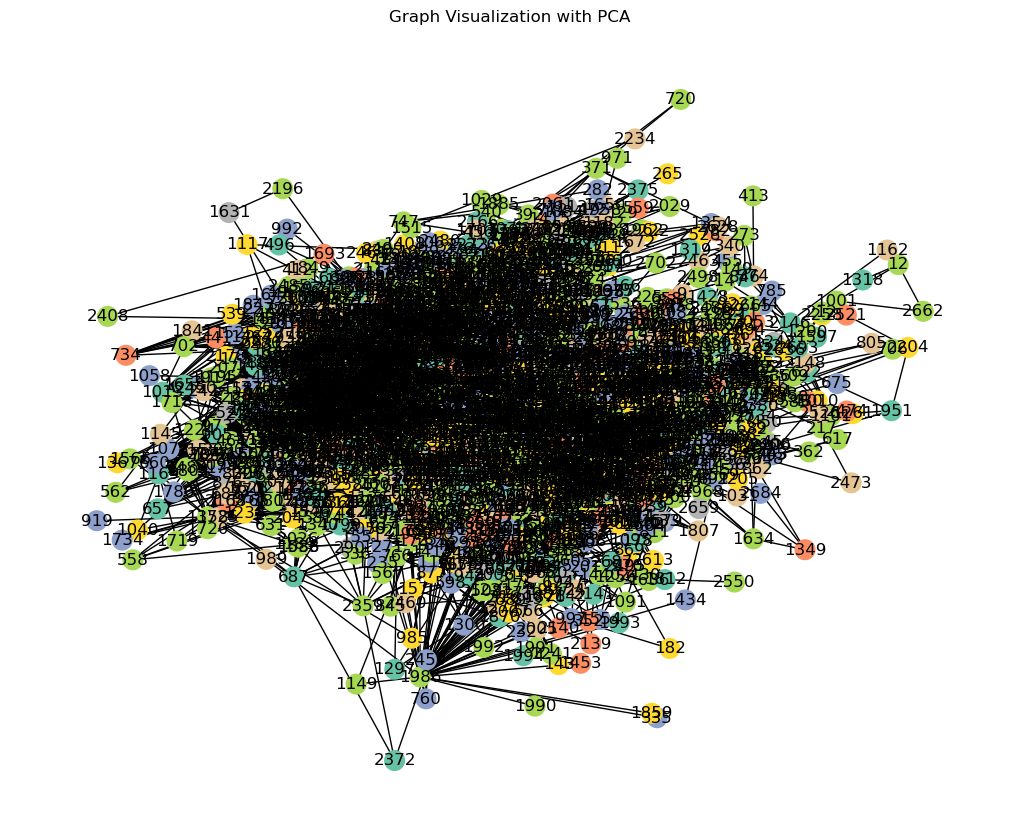

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize(z, color, edge_index):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())

    # Perform PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    z_reduced = pca.fit_transform(z)

    pos = {i: z_reduced[i] for i in range(len(z_reduced))}
    print(f"Number of nodes in G: {G.number_of_nodes()}")
    print(f"Number of edges in G: {G.number_of_edges()}")

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, node_color=color, with_labels=True, node_size=200, cmap="Set2")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Graph Visualization with PCA")
    plt.show()

# Create a mapping of node indices present in the graph G
node_indices = torch.unique(test_data.edge_index.flatten()).cpu().numpy()
color = test_data.y[node_indices].cpu().numpy()

# Detach the Tensor Before Converting to NumPy
z = model.encode(test_data.x, test_data.edge_index).detach().cpu().numpy()
z = z[node_indices]  # Select only the embeddings of nodes present in the graph

# Detach the Tensor Before Converting to NumPy
z = model.encode(test_data.x, test_data.edge_index).detach().cpu().numpy()
visualize(z, color, test_data.edge_index.cpu())

In [ ]:
print(f"Number of nodes in test_data.x: {test_data.num_nodes}")
print(f"Number of elements in color array: {len(color)}")
print(f"Shape of z (node embeddings): {z.shape}")
print(f"Shape of test_data.edge_index: {test_data.edge_index.shape}")

Number of nodes in test_data.x: 2708
Number of elements in color array: 2647
Shape of z (node embeddings): (2708, 16)
Shape of test_data.edge_index: torch.Size([2, 9502])


In [ ]:
model.eval()
with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    pred, label = test(test_data)
    auc = roc_auc_score(label.cpu(), pred.cpu())
    print(f'Test AUC: {auc:.4f}')

Test AUC: 0.7916


In [ ]:
# %conda install plotly

In [ ]:

import matplotlib.pyplot as plt

In [ ]:

import plotly.graph_objs as go
# Function to visualize the graph in 3D using plotly
def visualize_3d(z, color, edge_index, node_indices):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())

    # Perform PCA to reduce dimensionality to 3D
    pca = PCA(n_components=3)
    z_reduced = pca.fit_transform(z)

    # Create a mapping from original node indices to new indices
    node_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(node_indices)}

    edge_trace = []
    for edge in G.edges():
        if edge[0] in node_index_map and edge[1] in node_index_map:
            x0, y0, z0 = z_reduced[node_index_map[edge[0]]]
            x1, y1, z1 = z_reduced[node_index_map[edge[1]]]
            edge_trace.append(go.Scatter3d(
                x=[x0, x1], y=[y0, y1], z=[z0, z1],
                line=dict(width=0.5, color='#888'),
                hoverinfo='none',
                mode='lines'))

    node_trace = go.Scatter3d(
        x=z_reduced[:, 0], y=z_reduced[:, 1], z=z_reduced[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=color,  # Color by label
            colorscale='Viridis',
            opacity=0.8
        ),
        text=[str(i) for i in range(len(z_reduced))],
        hoverinfo='text'
    )

    fig = go.Figure(data=edge_trace + [node_trace],
                    layout=go.Layout(
                        title='3D Graph Visualization with PCA',
                        showlegend=False,
                        scene=dict(
                            xaxis=dict(title='PCA Component 1'),
                            yaxis=dict(title='PCA Component 2'),
                            zaxis=dict(title='PCA Component 3'),
                        )
                    ))
    fig.show()

# Create a mapping of node indices present in the graph G
node_indices = torch.unique(test_data.edge_index.flatten()).cpu().numpy()
node_indices = node_indices[node_indices < test_data.x.size(0)]  # Ensure all indices are within bounds
color = test_data.y[node_indices].cpu().numpy()

# Detach the Tensor Before Converting to NumPy
z = model.encode(test_data.x, test_data.edge_index).detach().cpu().numpy()
z = z[node_indices]  # Select only the embeddings of nodes present in the graph

# Debug prints
print(f"Number of nodes in test_data.x: {test_data.x.size(0)}")
print(f"Number of elements in color array: {len(color)}")
print(f"Shape of z (node embeddings): {z.shape}")
print(f"Shape of test_data.edge_index: {test_data.edge_index.shape}")

visualize_3d(z, color, test_data.edge_index.cpu(), node_indices)

Number of nodes in test_data.x: 2708
Number of elements in color array: 2647
Shape of z (node embeddings): (2647, 16)
Shape of test_data.edge_index: torch.Size([2, 9502])


In [ ]:
import numpy as np
def visualize_3d(z, color, edge_index, node_indices, num_nodes=200):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())

    # Randomly select a subset of nodes
    selected_indices = np.random.choice(len(node_indices), size=num_nodes, replace=False)
    subset_node_indices = node_indices[selected_indices]
    selected_z = z[selected_indices]
    selected_color = color[selected_indices]

    # Perform PCA to reduce dimensionality to 3D
    pca = PCA(n_components=3)
    z_reduced = pca.fit_transform(selected_z)

    # Create a mapping from original node indices to new indices
    node_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(subset_node_indices)}

    edge_trace = []
    for edge in G.edges():
        if edge[0] in node_index_map and edge[1] in node_index_map:
            x0, y0, z0 = z_reduced[node_index_map[edge[0]]]
            x1, y1, z1 = z_reduced[node_index_map[edge[1]]]
            edge_trace.append(go.Scatter3d(
                x=[x0, x1], y=[y0, y1], z=[z0, z1],
                line=dict(width=0.8, color='#888'),
                hoverinfo='none',
                mode='lines'))

    node_trace = go.Scatter3d(
        x=z_reduced[:, 0], y=z_reduced[:, 1], z=z_reduced[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=selected_color,  # Color by label
            colorscale='Viridis',
            opacity=0.8
        ),
        text=[str(i) for i in range(len(z_reduced))],
        hoverinfo='text'
    )

    fig = go.Figure(data=edge_trace + [node_trace],
                    layout=go.Layout(
                        title='3D Graph Visualization with PCA (Subset)',
                        showlegend=False,
                        scene=dict(
                            xaxis=dict(title='PCA Component 1'),
                            yaxis=dict(title='PCA Component 2'),
                            zaxis=dict(title='PCA Component 3'),
                        )
                    ))
    fig.show()

# Create a mapping of node indices present in the graph G
node_indices = torch.unique(test_data.edge_index.flatten()).cpu().numpy()
node_indices = node_indices[node_indices < test_data.x.size(0)]  # Ensure all indices are within bounds
color = test_data.y[node_indices].cpu().numpy() 

# Detach the Tensor Before Converting to NumPy
z = model.encode(test_data.x, test_data.edge_index).detach().cpu().numpy()
z = z[node_indices]  # Select only the embeddings of nodes present in the graph

# Debug prints
print(f"Number of nodes in test_data.x: {test_data.x.size(0)}")
print(f"Number of elements in color array: {len(color)}")
print(f"Shape of z (node embeddings): {z.shape}")
print(f"Shape of test_data.edge_index: {test_data.edge_index.shape}")

visualize_3d(z, color, test_data.edge_index.cpu(), node_indices)

Number of nodes in test_data.x: 2708
Number of elements in color array: 2647
Shape of z (node embeddings): (2647, 16)
Shape of test_data.edge_index: torch.Size([2, 9502])


In [ ]:
dataset[0][2]

Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])

Extract the subgraph for which I want to show the single papers network.
 identifies all nodes connected to the single paper. Then filter the edges to include only those connected nodes. Then remap node indices to be contiguous within the subgraph.

In [ ]:
def get_single_paper_subgraph(data, paper_index):
    # Identify connected nodes
    connected_nodes = torch.unique(data.edge_index[:, (data.edge_index[0] == paper_index) | (data.edge_index[1] == paper_index)])
    
    # Extract paper's feature vector
    paper_features = data.x[paper_index]
    # Extract the label of the paper
    paper_label = data.y[paper_index]
    # Extract labels of connected papers
    connected_labels = data.y[connected_nodes]
    
    # Create subgraph edge mask
    subgraph_edge_mask = ((data.edge_index[0].unsqueeze(1) == connected_nodes).any(dim=1)) & ((data.edge_index[1].unsqueeze(1) == connected_nodes).any(dim=1))
    
    # Filter edges based on the mask
    subgraph_edges = data.edge_index[:, subgraph_edge_mask]
    
    # Create a new index mapping for the subgraph
    node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(connected_nodes)}
    mapped_edges = torch.tensor([[node_mapping[edge.item()] for edge in edges] for edges in subgraph_edges.T], dtype=torch.long).T
    
    # Create the subgraph data
    subgraph_features = data.x[connected_nodes]
    subgraph_data = Data(x=subgraph_features, edge_index=mapped_edges)
    
    # return subgraph_data
    return {
        'features': paper_features,
        'label': paper_label,
        'connected_nodes': connected_nodes,
        'edges': subgraph_edges,
        'connected_labels': connected_labels,
        'subgraph_data': subgraph_data
    }


In [ ]:

# Function to visualize the graph in 3D using matplotlib
def visualize_subgraph(data):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    pos = nx.spring_layout(G)
    plt.figure(figsize=(4, 4))
    nx.draw(G, pos, node_size=50, with_labels=True, node_color='skyblue', edge_color='gray')
    plt.show()


In [ ]:

label_mapping = {
    0: 'Case Based',
    1: 'Genetic Algorithms',
    2: 'Neural Networks',
    3: 'Probabilistic Methods',
    4: 'Reinforcement Learning',
    5: 'Rule Learning',
    6: 'Theory'
}

def get_readable_info(data, paper_index):
    paper_info = get_single_paper_subgraph(data, paper_index)
    
    features = paper_info['features'].tolist()
    label = paper_info['label'].item()
    connected_nodes = paper_info['connected_nodes'].tolist()
    edges = paper_info['edges'].tolist()
    connected_labels = paper_info['connected_labels'].tolist()
    
    # Visualize the subgraph
    visualize_subgraph(paper_info['subgraph_data'])
    print("Paper Index:", paper_index)

    print(f"Features (Summary): {features[:10]}... (total {len(features)} features)")
    print(f"Label: {label_mapping[label]}")
    print("Connected Nodes and their Labels:")
    for node, label in zip(connected_nodes, connected_labels):
        print(f"  Node {node}: {label_mapping[label]}")
    print("Edges (Citations):")
    for src, dst in zip(edges[0], edges[1]):
        print(f"  Node {src} cites Node {dst}")



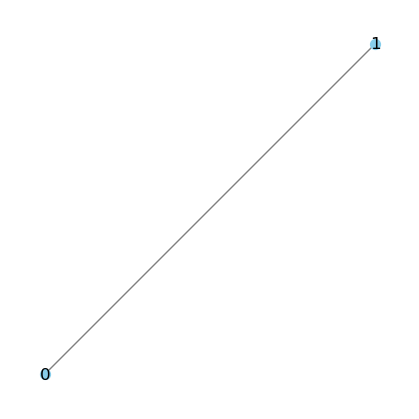

Paper Index: 3
Features (Summary): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]... (total 1433 features)
Label: Case Based
Connected Nodes and their Labels:
  Node 3: Case Based
  Node 2544: Case Based
Edges (Citations):
  Node 3 cites Node 2544
  Node 2544 cites Node 3


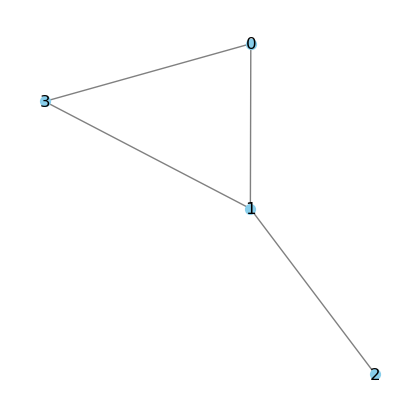

Paper Index: 1017
Features (Summary): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]... (total 1433 features)
Label: Probabilistic Methods
Connected Nodes and their Labels:
  Node 591: Case Based
  Node 1017: Probabilistic Methods
  Node 1475: Case Based
  Node 2472: Case Based
Edges (Citations):
  Node 591 cites Node 2472
  Node 1017 cites Node 2472
  Node 591 cites Node 1017
  Node 1017 cites Node 1475
  Node 2472 cites Node 591
  Node 2472 cites Node 1017
  Node 1017 cites Node 591
  Node 1475 cites Node 1017


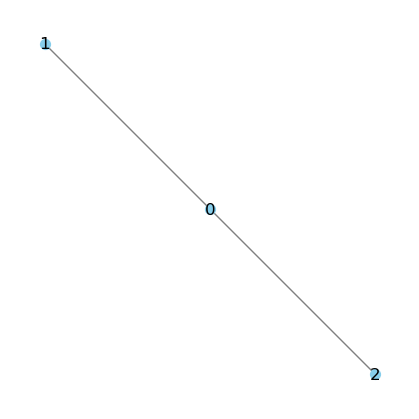

Paper Index: 798
Features (Summary): [0.0, 0.0, 0.05263157933950424, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]... (total 1433 features)
Label: Reinforcement Learning
Connected Nodes and their Labels:
  Node 798: Reinforcement Learning
  Node 1381: Reinforcement Learning
  Node 1793: Reinforcement Learning
Edges (Citations):
  Node 798 cites Node 1793
  Node 798 cites Node 1381
  Node 1793 cites Node 798
  Node 1381 cites Node 798


In [ ]:

# Example: Get subgraph for a single paper
for i in range(0, 3):
    paper_index = np.random.randint(2708)  # Change this to the index of the paper you want to predict
    single_paper_subgraph = get_readable_info(test_data, paper_index)

    # Visualize the subgraph
    # visualize_subgraph(single_paper_subgraph['subgraph_data'])
    # print("Paper Index:", paper_index)
    # print("Features:", single_paper_subgraph['features'])
    # print("Label:", single_paper_subgraph['label'])
    # print("Connected Nodes:", single_paper_subgraph['connected_nodes'])
    # print("Edges:", single_paper_subgraph['edges'])
    # print("Connected Labels:", single_paper_subgraph['connected_labels'])

In [ ]:
#ques for GPT
#"Edges represent citation links between papers. An edge from node i to node j indicates that paper i cites paper j." in this how do we know that i cites paper j in this network? is it done by directed edges? so do we have these edges directed within hte cora dataset itself?


In [ ]:

# Predefined vocabulary from the CORA dataset
vocabulary = ['graph', 'neural', 'networks', 'citation', 'deep', 'learning', 'natural', 'language', 'processing', 'convolutional', 'applications']
vocab_size = len(vocabulary)

# Function to create a feature vector for a new paper
def create_feature_vector(paper_text, vocabulary):
    tokens = paper_text.lower().split()
    feature_vector = [1 if word in tokens else 0 for word in vocabulary]
    return torch.tensor(feature_vector, dtype=torch.float)

# Function to predict connections for a new paper
def predict_connections(model, new_paper_vector, data):
    new_paper_vector = new_paper_vector.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        new_paper_embedding = model.encode(new_paper_vector, data.edge_index)
        existing_embeddings = model.encode(data.x, data.edge_index)
        similarities = torch.matmul(new_paper_embedding, existing_embeddings.t())
        predicted_connections = torch.topk(similarities, k=5)  # Get top 5 connections
        return predicted_connections.indices

# Function to display the predicted connections and their topics
def display_predictions(predicted_indices, data, label_mapping):
    for idx in predicted_indices:
        paper_label = data.y[idx].item()
        print(f"Paper Index: {idx}, Topic: {label_mapping[paper_label]}")

# Example new paper text
new_paper_text = "Graph neural networks for new applications in citation analysis"
new_paper_vector = create_feature_vector(new_paper_text, vocabulary)

# Initialize and load your trained model
# model = GraphSAGE(in_channels=vocab_size, out_channels=64)
# Assuming you have trained and saved your model previously
# model.load_state_dict(torch.load('path_to_your_model.pth'))

# Predict connections
predicted_indices = predict_connections(model, new_paper_vector, train_data)

# Display the predicted connections and their topics
print("Top predicted connections (paper indices and topics):")
display_predictions(predicted_indices.cpu().numpy(), train_data, label_mapping)

IndexError: Found indices in 'edge_index' that are larger than 0 (got 2707). Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 1) in your node feature matrix and try again.